In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import train and test files
path_test = "C:\\CSE\\Linear Reg\\Test.csv"
path_train = "C:\\CSE\\Linear Reg\\Train.csv"
train_file = pd.read_csv(f"{path_train}")
test_file = pd.read_csv(f"{path_test}")
# Drop unnecessary columns (first pass)
train_file = train_file.drop(columns=["Unnamed: 0"], errors="ignore")
test_file = test_file.drop(columns=["Unnamed: 0"], errors="ignore")

Extract the numeric values from columns (integer values)

In [3]:
# Extract numeric parts from strings for columns with mixed data types
train_file["Mileage"] = train_file["Mileage"].str.extract(r"([\d\.]+)").astype(float)
train_file["Engine"] = train_file["Engine"].str.extract(r"([\d\.]+)").astype(float)
train_file["Power"] = train_file["Power"].str.extract(r"([\d\.]+)").astype(float)
test_file["Mileage"] = test_file["Mileage"].str.extract(r"([\d\.]+)").astype(float)
test_file["Engine"] = test_file["Engine"].str.extract(r"([\d\.]+)").astype(float)
test_file["Power"] = test_file["Power"].str.extract(r"([\d\.]+)").astype(float)

Fill the empty cells with median value to keep its effect minimum

In [4]:
# Fill missing values with median for certain columns
for col in ["Mileage", "Engine", "Power", "Seats"]:
    if col in train_file.columns:
        train_file[col] = train_file[col].fillna(train_file[col].median())
        test_file[col] = test_file[col].fillna(test_file[col].median())


Extract columns with numeric value to tabulate correlation table

In [5]:
numeric_columns = train_file.select_dtypes(include=[np.number]).columns
train_file_numeric = train_file[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = train_file_numeric.corr()
print(correlation_matrix)

                       Year  Kilometers_Driven   Mileage    Engine     Power  \
Year               1.000000          -0.426688  0.328636 -0.052797  0.028468   
Kilometers_Driven -0.426688           1.000000 -0.140579  0.144822  0.001961   
Mileage            0.328636          -0.140579  1.000000 -0.571010 -0.486953   
Engine            -0.052797           0.144822 -0.571010  1.000000  0.859990   
Power              0.028468           0.001961 -0.486953  0.859990  1.000000   
Seats              0.021399           0.184737 -0.277417  0.384655  0.094171   
Price              0.311836          -0.161540 -0.296908  0.648792  0.758480   

                      Seats     Price  
Year               0.021399  0.311836  
Kilometers_Driven  0.184737 -0.161540  
Mileage           -0.277417 -0.296908  
Engine             0.384655  0.648792  
Power              0.094171  0.758480  
Seats              1.000000  0.053150  
Price              0.053150  1.000000  


Correlation Table
here its seen Kilometers_Driven and Mileage have -ve correlation with price. It is better to not consider them as a feature input for training data.
It can also be observed engine has high correlation with power. So engine can be dropped.
the Categorical columns with n types of input can be branced into n-1 columns, with all 0 indicating nth condition.
this is achieved using get_dummies
the irrelevant columns are stored in string and excluded 

In [6]:
# Convert categorical columns to dummies
cats = ["Fuel_Type", "Transmission", "Owner_Type", "Location"]
train_file = pd.get_dummies(train_file, columns=cats, drop_first=True)
test_file = pd.get_dummies(test_file, columns=cats, drop_first=True)

# Define columns to exclude (exclude from test_file)
columns_to_exclude = ["Price", "Name", "Engine", "Seats","Year","Kilometers_Driven"]

columns = test_file.columns
columns = [item for item in columns if item not in columns_to_exclude]

In [7]:
# Define the target column
y_columns = "Price"
x_columns = columns

print("updated column names - ")
print("\ny - ")
print(y_columns)
print("\nx- ")
print(x_columns)


updated column names - 

y - 
Price

x- 
['Mileage', 'Power', 'Fuel_Type_Electric', 'Fuel_Type_Petrol', 'Transmission_Manual', 'Owner_Type_Fourth & Above', 'Owner_Type_Second', 'Owner_Type_Third', 'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi', 'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi', 'Location_Kolkata', 'Location_Mumbai', 'Location_Pune']


features are stored in x_train as array of n dimension, where n is the number of feature
    feat1   feat2 .......
d1
d2
.
.
.
ie for X[m][n] - there are m items with n features 
the values (relevant) of X (features) are extracted from file and stored in X_train
same for y_train
both are converted to datatype float to avoid loss of data and error further down the code

In [8]:
x_train = train_file[x_columns].values        #store features as array of n dimension(n = number of feature)
y_train = train_file[y_columns].values
x_test = test_file[x_columns].values        
y_test = test_file[y_columns].values
m = x_train.shape[1]

x_train = x_train.astype(float)
y_train = y_train.astype(float)

Scale down using Z-score 
Z = (X-mean)/standard_deviation
scale down both train and test data for uniformity in plotting later.

In [9]:
for i in range(m):      #scale down(Z scale) (x-mean)/st.deviation
 x_train[:,i] = (x_train[:,i] - np.mean(x_train[:,i]))/np.std(x_train[:,i])
m = x_test.shape[1]
for i in range(m):
 x_test[:,i] = (x_test[:,i] - np.mean(x_test[:,i]))/np.std(x_test[:,i])
n= len(y_train)        #scale down(Z scale) (y-mean)/st.deviation
for i in range(n):
 y_train[i] = (y_train[i] - np.mean(y_train))/np.std(y_train)
 
 n= len(y_test)        #scale down(Z scale) (y-mean)/st.deviation
for i in range(n):
 y_test[i] = (y_test[i] - np.mean(y_test))/np.std(y_test)

#initialise  {initialise w to zero array with elements equal to number of features..ie. column}
w = np.zeros(m)  #weights = no of features(no of columns in x_train)
b = 0 #bias
a = 0.001 #learing rate
ite = 6000 

Linear function f = w*x + b (usind dot product)

In [10]:
def function(w, b, x):
    return np.dot(x, w) + b

define Cost function for all the data(rows in x_train)

In [11]:

def cost_fun(w, b, x, y):  # Cost function
    m = x.shape[0]  # Number of training examples(rows)
    total_cost = 0
    for i in range(m):
        total_cost += (function(w, b, x[i]) - y[i])**2    # Squared error
    return (1 / (2 * m)) * total_cost  # Average cost

Define Gradient Descent function

In [12]:

def gradient_descent(w, b, x, y, a, iteration):
    m = x.shape[0] #no of training example (rows)
    cost_history = []
    w_history = []
    
    for j in range(iteration):
        dj_dw = np.zeros_like(w)  # Initialize gradient for w
        dj_db = 0  # Initialize gradient for b
        
        for i in range(m):
            dj_dw +=(function(w, b, x[i]) - y[i]) * x[i]  
            dj_db += function(w, b, x[i]) - y[i]  
      
        w = w - (1/m) * a * dj_dw
        b = b - (1/m) * a * dj_db
        
        # Compute and save the cost for the current iteration
        cost = cost_fun(w, b, x, y)
        cost_history.append(cost)
        w_history.append(w)
    
    return w, b, cost_history, w_history

In [13]:
# Run gradient descent aldorithm for ite no of iterations 
w, b, cost_history, w_history = gradient_descent(w, b, x_train, y_train, a, ite)

The linear model is predicted, with ideal values of weights and bias.
The aim is to decrease the final cost function value for corresponding weights and bias

In [14]:
# Final output
final_cost = cost_fun(w, b, x_train, y_train)
print("\nOUTPUT\n")
print(f"Final value of w = {w}, and b = {b} for a = {a}")
print(f"Final value of cost function = {final_cost}")


OUTPUT

Final value of w = [ 0.03011275  0.88745946  0.00396736 -0.17048587 -0.27322041 -0.01093137
 -0.12610993 -0.0875946   0.08669203 -0.01305511  0.13408252 -0.0515484
  0.0355188  -0.00466554  0.08276344 -0.05592449 -0.03667154 -0.01349072], and b = 0.70688541594101 for a = 0.001
Final value of cost function = 1.023642282286476


Define a function to caliculate R square value to evaluate performance
Rsquare = 1-(ssr/sst)

In [18]:
# Rsquare calculation
def Rsquare(y,y_predict):
    ssr = np.sum((y-y_predict)**2)
    sst = np.sum((y - y.mean())**2)
    return 1-(ssr/sst)

In [19]:
#compare with test.csv and train.csv using Rsquare value
print(f"\nR square value for Train data  {Rsquare(y_train,function(w,b,x_train))}")
print(f"\nR square value for Test data {Rsquare(y_test,function(w,b,x_test))}")


R square value for Train data  0.41063147553950197

R square value for Test data 0.413743343010629


As we are plotting actual vs prediction we need a reference line x = y to visualize the performance of model

In [20]:
#create a reference x=y line
y_min = min(min(y_train),min(function(w,b,x_train)))
y_max= max(max(y_train),max(function(w,b,x_train)))
y = np.linspace(y_min,y_max, 500)  # Create 500 points between min and max value
x = y  # x is equal to y

Plot actual vs prediction with x = y to get better understanding of data

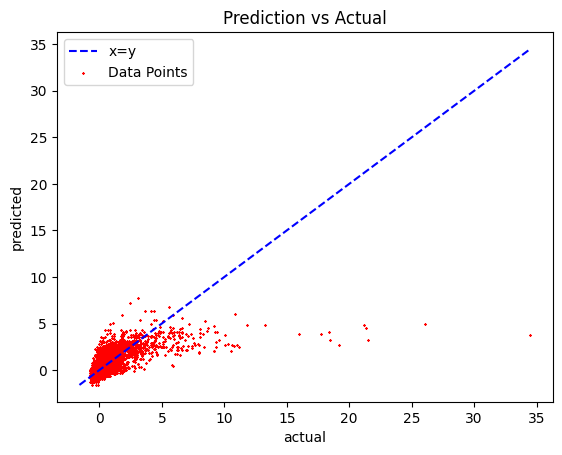

In [21]:
#plot actual vs prediction
plt.plot(x, y, color="blue",linestyle = "--", label="x=y")
plt.scatter(y_train,function(w,b,x_train), color='red', marker='x', s=1, label='Data Points')
plt.xlabel("actual")
plt.ylabel("predicted")
plt.title("Prediction vs Actual")
plt.legend()
plt.show()